# Heteroskedasticity and Bias correction using linear transformations

This notebook works through an idea for correcting heteroskedasticity which uses rotation matrices to align samples. Previous iterations of seqpyplot (SPPLOT v0.3 and below) output a scatter plot that plots the expression values of control and treated samples and against their means. These plots revealed what appeared to be a bias where one sample tended towards overall higher expression than the other. Given the type of data being analyzed (Time series RNA seq data), it seemedunlikely that there would be such a bias inherent to the experiment.

In this notebook, I propose a method for correcting this bias using linear regression and linear transformations to rotate one of the two samples prior to differential experesssion inference. 

The steps to performing this transformation are as follows
1. For a given sample pair, compute the mean. 
2. For each sample and its repestive mean computed in step 1, perform linear regression to compute a regression coefficient (a line of best fit) through the sample/mean pair as well as a bias.
3. Zero out the sample bias by addition or subtraction across all points.
4. If the regression coeffieicients do not match, use the coefficients to compute the angle difference.
5. Compute a rotation matrix to rotate the data about the origin until they match, resulting in proper alignment between the control and treated samples.


References:
    Rotation Matrices: https://en.wikipedia.org/wiki/Rotation_matrix

In [31]:
import pandas as pd
import numpy as np
from random import randint as rand
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from scipy.linalg import svd

from seqpyplot.container.data_container import DataContainer
from seqpyplot.parsers.config_parser import config_parser
from pathlib import Path

from matplotlib import rcParams

rcParams['figure.figsize'] = (15, 15)

# Helper functions

In [34]:
def calc_theta(coef1, coef2):
    "Returns an angle in radians"
    return np.abs(
       np.arctan(np.abs(coef1 - coef2) / (1. + (coef1 * coef2)))
   )

In [36]:
def compute_rot_mat(rad, coef=.5):
    " Compute a rotation matrix using rad for a given regression coefficient "
    if coef < 1.0:
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
    else:
        rotation_matrix = np.array([[np.cos(rad), np.sin(rad)],
                                    [-np.sin(rad), np.cos(rad)]])  
    return rotation_matrix

# Simple example of line rotation
Example of rotating a line around the origin to match the slope of another line

In [281]:
slope1 = 1.1
slope2 = 2.0

line1 = np.array([slope1 * x for x in range(10)])
line2 = np.array([slope2 * x for x in range(10)])

xs = list(range(10))

#### Original Lines

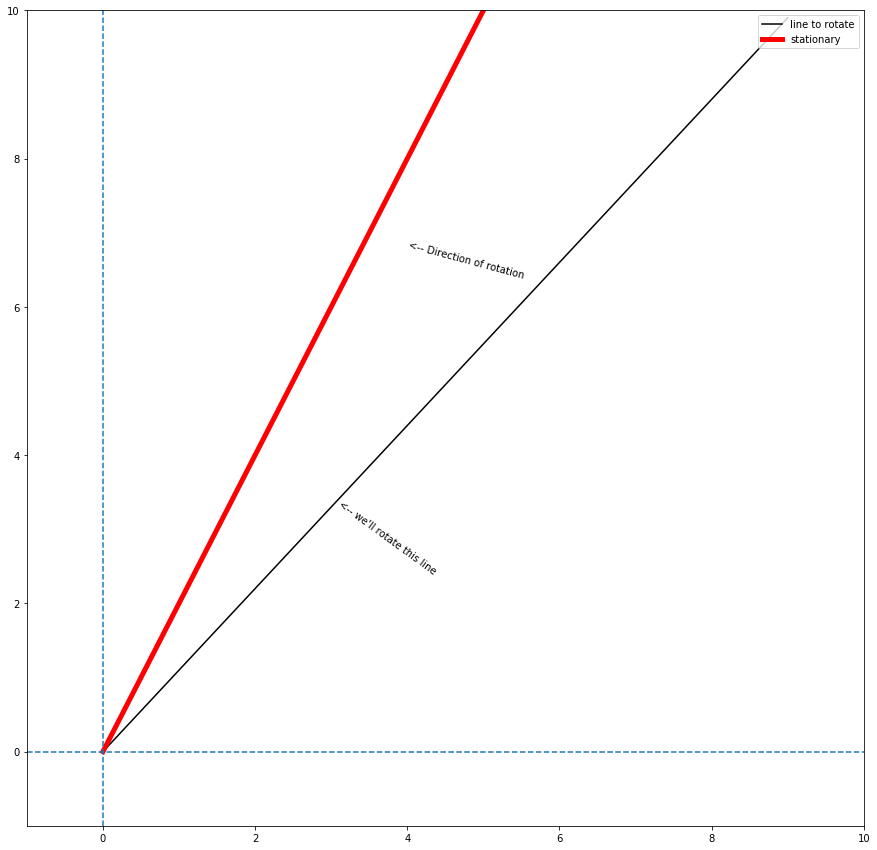

In [286]:
# Plot lines
plt.plot(xs, line1, color='black', label='line to rotate');
plt.plot(xs, line2, color='red', linewidth=5, label='stationary');
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--');

plt.annotate(s=('<-- we\'ll rotate this line'), xy=(xs[3]+0.08, line1[3]), rotation=-36)
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[3] + 1, line1[3]+3.5), rotation=-15)

plt.ylim((-1, 10))
plt.xlim((-1, 10))
plt.legend(loc='upper right');

#### Rotated lines

In [35]:
# Compute angle
angle_diff = calc_theta(slope1, slope2)
angle_diff

0.27416745111965873

In [37]:
# Compute rotation matrix
rot_matrix = compute_rot_mat(angle_diff)
rot_matrix

array([[ 0.96265094, -0.27074558],
       [ 0.27074558,  0.96265094]])

In [38]:
# rotate line 1 (black line)
new_line1 = list()
for x, y in zip(xs, line1):
    # need shape [[#], [#]]
    old_point = np.array([[x], [y]])
    new_point = np.dot(rot_matrix, old_point)
    new_line1.append(new_point)
new_line1 = np.squeeze(np.asarray(new_line1))

In [114]:
xs[6], line1[6]

(6, 6.6000000000000005)

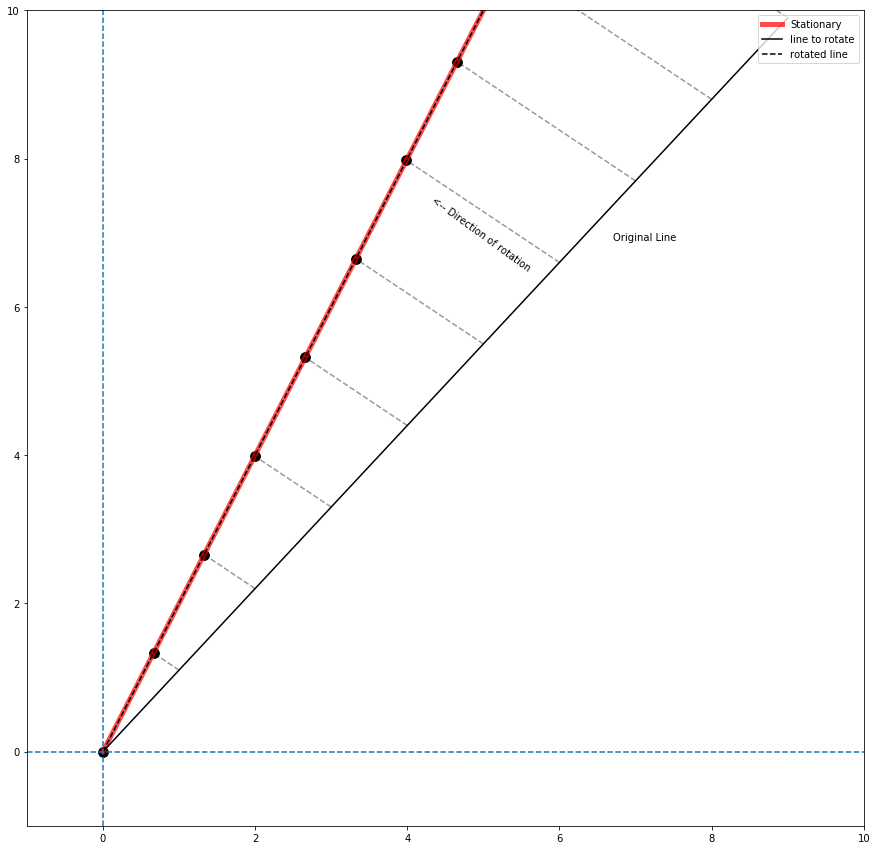

In [216]:
plt.plot(xs, line2, color='red', linewidth=5, alpha=0.7, label='Stationary');

plt.plot(xs, line1, color='black', label='line to rotate')
plt.scatter(new_line1[:, 0], new_line1[:, 1], color='black', s=95)
plt.plot(new_line1[:, 0], new_line1[:, 1], color='black', linestyle='--', label='rotated line')

plt.annotate(s=('Original Line'), xy=(xs[6] + 0.7, line1[6]+0.3))
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[6] - 1.7, line1[6]+0.8), rotation=-36)

plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')

for (x1, y1), (x2, y2) in zip(zip(xs, line1), new_line1):
    plt.plot([x1, x2], [y1, y2], linestyle='--', color='black', alpha=0.4)

plt.ylim((-1, 10))
plt.xlim((-1, 10));
plt.legend(loc='upper right');

# Examle using raw expression Data
(No TMM normalization)

In [180]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

In [181]:
# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

In [43]:
cols = data.columns
cols

Index(['D1_Cont', 'D2_Cont', 'D3_Cont', 'D1_Treat', 'D2_Treat', 'D3_Treat'], dtype='object')

In [44]:
df = data[['D1_Cont', 'D1_Treat']]
df.loc[:, 'mean'] = df.mean(axis=1)

C:\Users\paule\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\paule\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [45]:
df.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,16,30,23.0
0610007P14Rik,333,364,348.5
0610009B22Rik,150,220,185.0
0610009L18Rik,20,25,22.5
0610009O20Rik,680,805,742.5


In [202]:
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

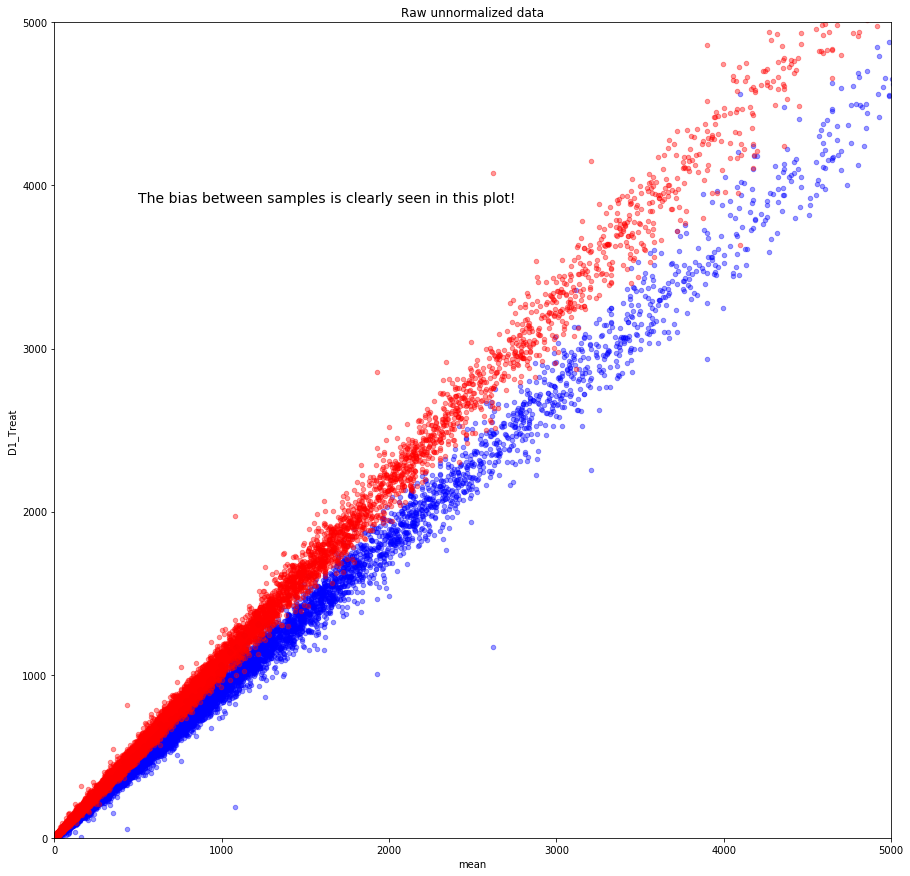

In [203]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
plt.annotate('The bias between samples is clearly seen in this plot!', (500, 3900), fontsize=14)
ax.set_title("Raw unnormalized data");

[[1.09646016]] [-1.66985095]
[[0.91183697]] [5.21303275]


C:\Users\paule\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\paule\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
No handles with labels found to put in legend.


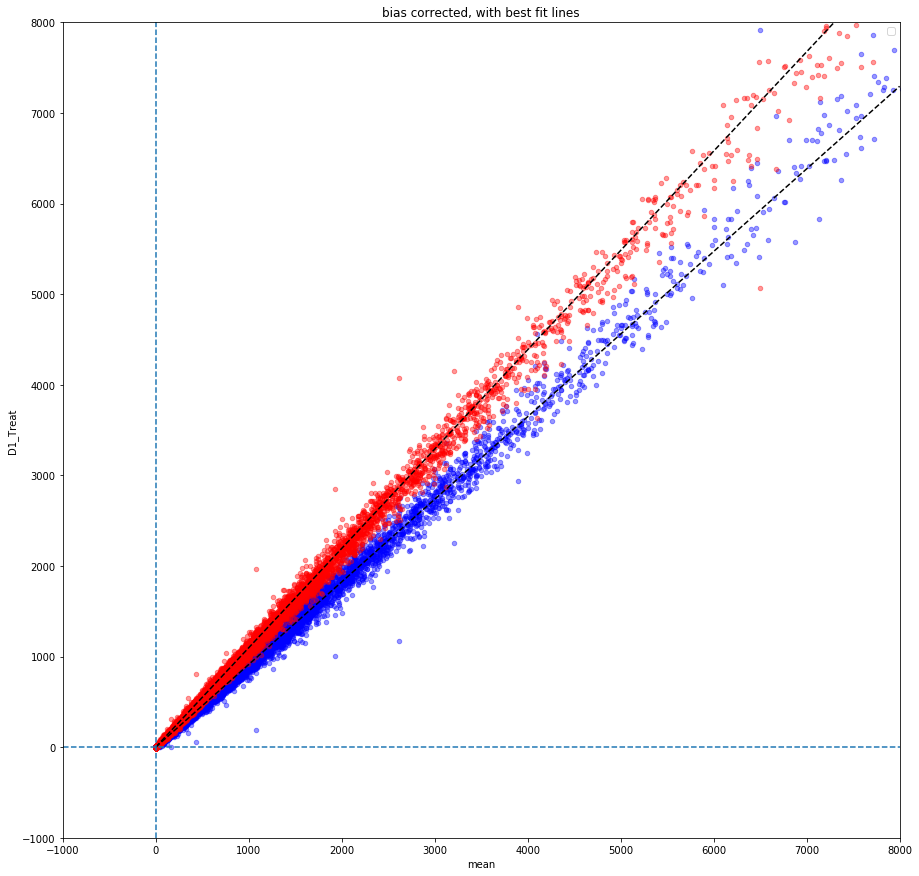

In [207]:
# Quick reset for this cell
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

# define regression objects
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# fit regression
regCont.fit(d1['D1_Cont'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))
regTreat.fit(d2['D1_Treat'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))

print(regCont.coef_, regCont.intercept_)
print(regTreat.coef_, regTreat.intercept_)

# Correct bias
d1['D1_Cont'] = d1['D1_Cont'] - regCont.intercept_
d2['D1_Treat'] = d2['D1_Treat'] - regTreat.intercept_

# Plot regression lines
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 8000), ylim=(0, 8000), ax=ax, color='red',  alpha=0.4)
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 8000], [0.0, regTreat.coef_ * 8000], linestyle='--', color='black');
ax.set_title("bias corrected, with best fit lines");

plt.ylim((-1000, 8000))
plt.xlim((-1000, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

#### Compute rotation linear transformation

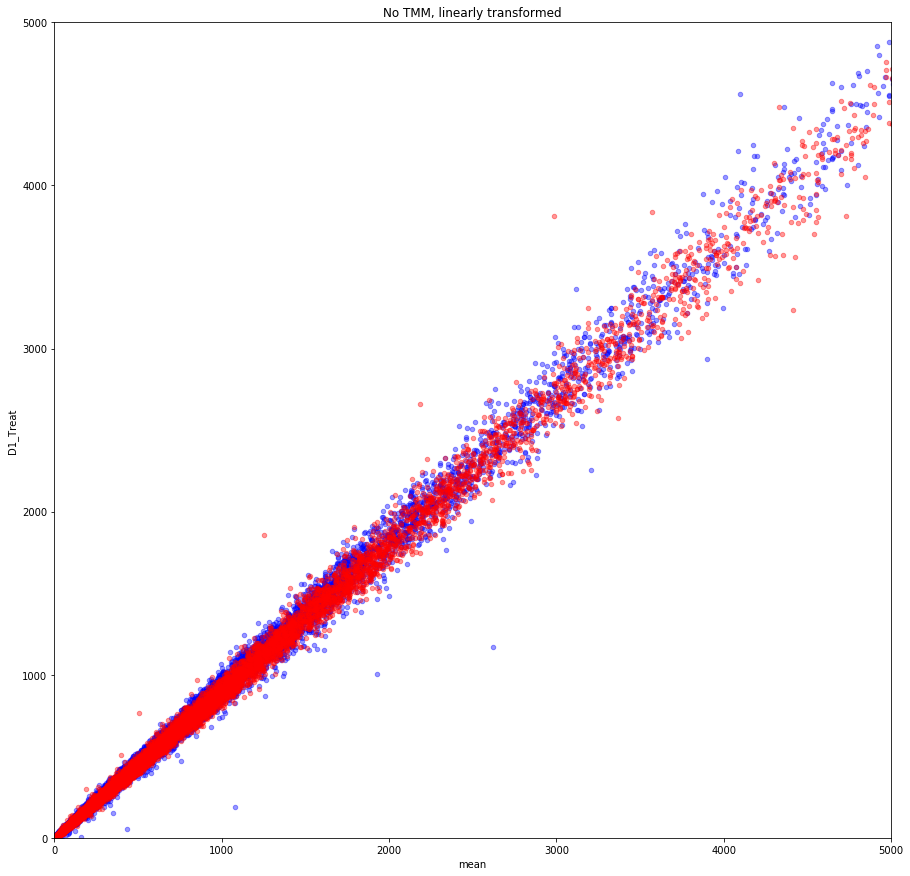

In [208]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
correction_theta  # in radians

rotation_matrix = compute_rot_mat(correction_theta)
rotation_matrix

new_treat = np.array([np.dot(rotation_matrix, d2.values[i, :]) for i in range(len(d2.values))])
new_treat

d2_cor = d2.copy()
d2_cor.loc[:, 'D1_Treat'] = new_treat[:, 0]
d2_cor.loc[:, 'mean'] = new_treat[:, 1]

fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
d2_cor.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("No TMM, linearly transformed");

Successs! We have eliminated the sample divergence!

# Use TMM before linear transformation

In [294]:
# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

data.head()

,D1_Cont,D2_Cont,D3_Cont,D1_Treat,D2_Treat,D3_Treat
gene,,,,,,
0610005C13Rik,16.0,25.0,24.0,29.743831,22.167881,20.106753
0610007P14Rik,333.0,491.0,418.0,360.891812,553.189405,393.087028
0610009B22Rik,150.0,242.0,164.0,218.121425,266.014577,176.939429
0610009L18Rik,20.0,49.0,33.0,24.786526,26.198405,30.160130
0610009O20Rik,680.0,801.0,794.0,798.126123,974.379152,775.115341


In [295]:
normed_df = data[['D1_Cont', 'D1_Treat']]
normed_df.loc[:, 'mean'] = df.mean(axis=1)

normed_d1 = normed_df[['D1_Cont', 'D1_Treat', 'mean']]

C:\Users\paule\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\paule\Anaconda3\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [297]:
normed_d1.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,16.0,29.743831,17.846298
0610007P14Rik,333.0,360.891812,216.535087
0610009B22Rik,150.0,218.121425,130.872855
0610009L18Rik,20.0,24.786526,14.871915
0610009O20Rik,680.0,798.126123,478.875674


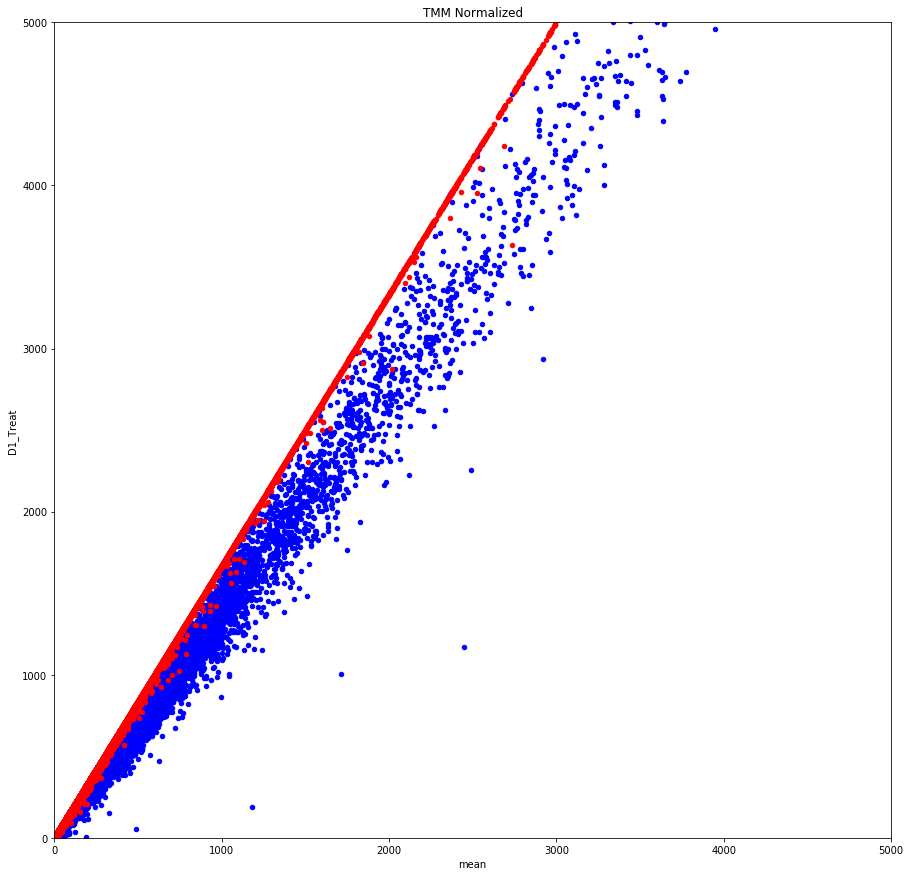

In [293]:
fig, ax = plt.subplots()
normed_d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue')
normed_d1.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red');
ax.set_title("TMM Normalized");

In [61]:
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(d1['D1_Cont'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))
regTreat.fit(d2['D1_Treat'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
regCont.coef_, regCont.intercept_

(array([[1.09646016]]), array([-1.66985095]))

In [63]:
regTreat.coef_, regTreat.intercept_

(array([[0.91183697]]), array([5.21303275]))

In [64]:
d2.head()

,D1_Treat,mean
gene,,
0610005C13Rik,29.743831,22.871915
0610007P14Rik,360.891812,346.945906
0610009B22Rik,218.121425,184.060712
0610009L18Rik,24.786526,22.393263
0610009O20Rik,798.126123,739.063062


In [65]:
d1['D1_Cont'] = d1['D1_Cont'] - regCont.intercept_
d2['D1_Treat'] = d2['D1_Treat'] - regTreat.intercept_

C:\Users\paule\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\paule\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


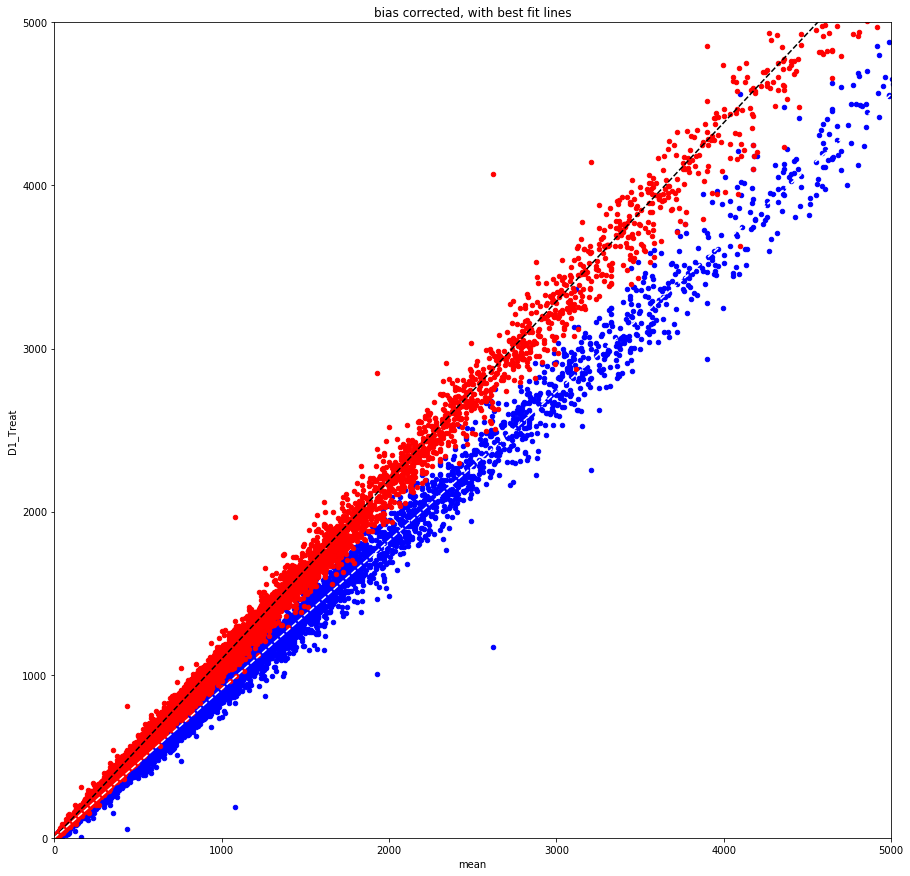

In [66]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue')
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red')
plt.plot([0, 5000], [0.0, regCont.coef_ * 5000], linestyle='--', color='black')
plt.plot([0, 5000], [0.0, regTreat.coef_ * 5000], linestyle='--', color='white');
ax.set_title("bias corrected, with best fit lines");

Compute linear transformation

In [67]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
correction_theta  # in radians

0.09206019892007936

In [68]:
rotation_matrix = compute_rot_mat(correction_theta)
rotation_matrix

array([[ 0.99576545, -0.09193022],
       [ 0.09193022,  0.99576545]])

In [69]:
new_treat = np.array([np.dot(rotation_matrix, d2.values[i, :]) for i in range(len(d2.values))])
new_treat

array([[  22.32430092,   25.0301847 ],
       [ 322.27782779,  378.17437457],
       [ 195.08607996,  202.85401337],
       ...,
       [2543.62033589, 2815.71462264],
       [   5.41984569,   14.00632418],
       [ 326.82599472,  372.0494744 ]])

In [70]:
d2_cor = d2.copy()
d2_cor.loc[:, 'D1_Treat'] = new_treat[:, 0]
d2_cor.loc[:, 'mean'] = new_treat[:, 1]

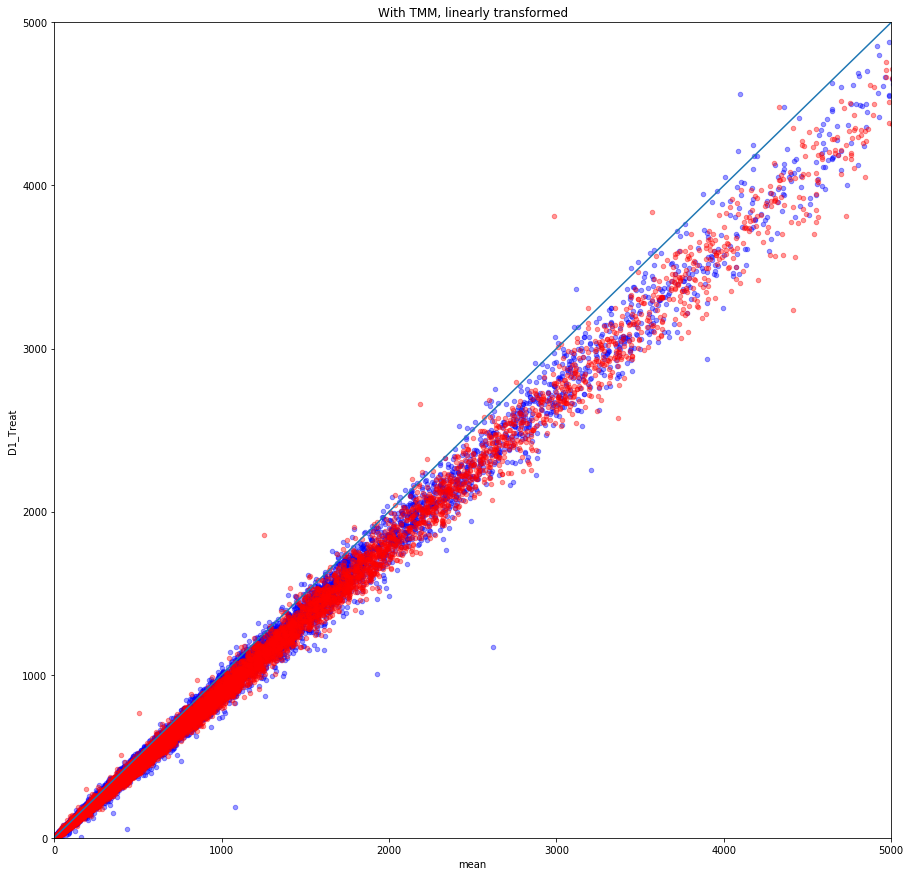

In [84]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
d2_cor.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("With TMM, linearly transformed");
plt.plot([0, 5000], [0, 5000])

In [72]:
d2_cor.head()

,D1_Treat,mean
gene,,
0610005C13Rik,22.324301,25.030185
0610007P14Rik,322.277828,378.174375
0610009B22Rik,195.086080,202.854013
0610009L18Rik,17.431990,24.097833
0610009O20Rik,721.613233,808.826136


In [73]:
reg = LinearRegression(fit_intercept=True)
reg.fit(d2_cor['mean'].values.reshape(-1, 1), d2_cor['D1_Treat'].values.reshape(-1, 1), )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

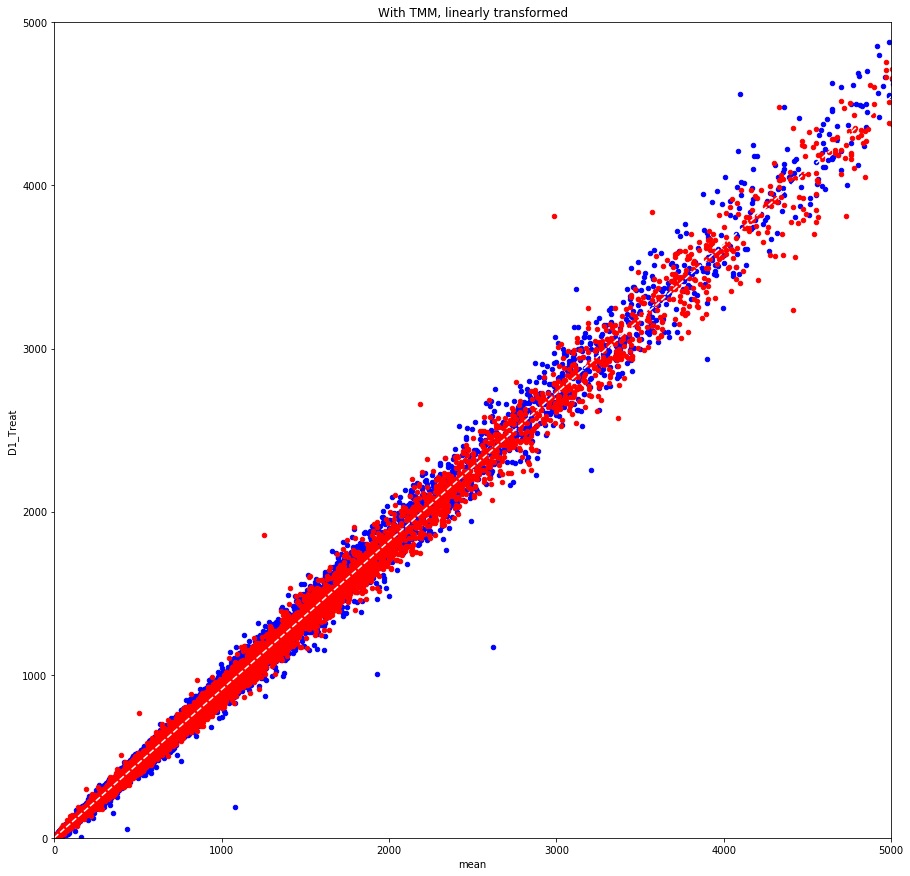

In [74]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue')
d2_cor.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red');
plt.plot([0, 5000], [0.0, reg.coef_ * 5000], linestyle='--', color='white')
# plt.plot([0, 5000], [0.0, regCont.coef_ * 5000], linestyle='--', color='black');
# plt.plot([0, 5000], [0.0, regTreat.coef_ * 5000], linestyle='--', color='blue');

ax.set_title("With TMM, linearly transformed");

In [75]:
calc_theta(1.0, regCont.coef_)

array([[0.04597854]])

In [76]:
calc_theta(1.0, regTreat.coef_)

array([[0.04608166]])

The most straightforward approach is probably going to be to transform the data so that each one line is brought to the slope of another. Once both samples are transformed, then the means will be dropped, and then recomputed. This will cause the data to be reordered (since we order based on the mean). Once plotted, the redistributed data should then be in a form that is ready for filtering.

# Choosing thresholds for outlier cutoffs

Before performing rotation correction, its a good idea to eliminate some of the worst outlier offenders before performing linear regression. To do this, we can calculate summary statistics on the sample pair, and 

In [79]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

df = data[['D1_Cont', 'D1_Treat']].copy()
df.loc[:, 'mean'] = df.mean(axis=1)
df.loc[:, 'var'] = (df['D1_Cont'] - df['mean']).abs()
df.loc[:, 'diff'] = (df['D1_Cont'] - df['D1_Treat']).abs()


In [80]:
described = df[df['diff'] > 0.0].describe(percentiles=[x /10. for x in range(10)])

In [81]:
deef = described.copy()
deef.drop(['count', 'mean', 'std', 'min', 'max'], axis=0, inplace=True)
columns = deef.columns
idx = deef.index.tolist()

In [82]:
deef

,D1_Cont,D1_Treat,mean,var,diff
0%,0.0,0.000000,0.495731,0.000470,0.000940
10%,1.0,1.982922,1.495731,0.500000,1.000000
20%,6.0,7.931688,6.474383,1.051704,2.103407
30%,19.0,24.786526,21.414610,2.512808,5.025617
40%,60.0,74.359577,68.149902,5.548374,11.096748
50%,145.0,174.497140,160.714414,11.615746,23.231492
60%,274.0,328.173598,301.625225,21.415550,42.831100
70%,454.0,537.371874,496.638973,38.646102,77.292204
80%,763.0,905.203913,835.289814,67.705364,135.410728
90%,1410.0,1671.603284,1545.322989,136.783154,273.566309


Using the 75th percentile is typical practice. Based on thse summary stats, it doens't seem unreasonable to take up to the 90th percentile, however a conservative estimate is likely to improve results.

/Users/pgradie/miniconda-3.9.1/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


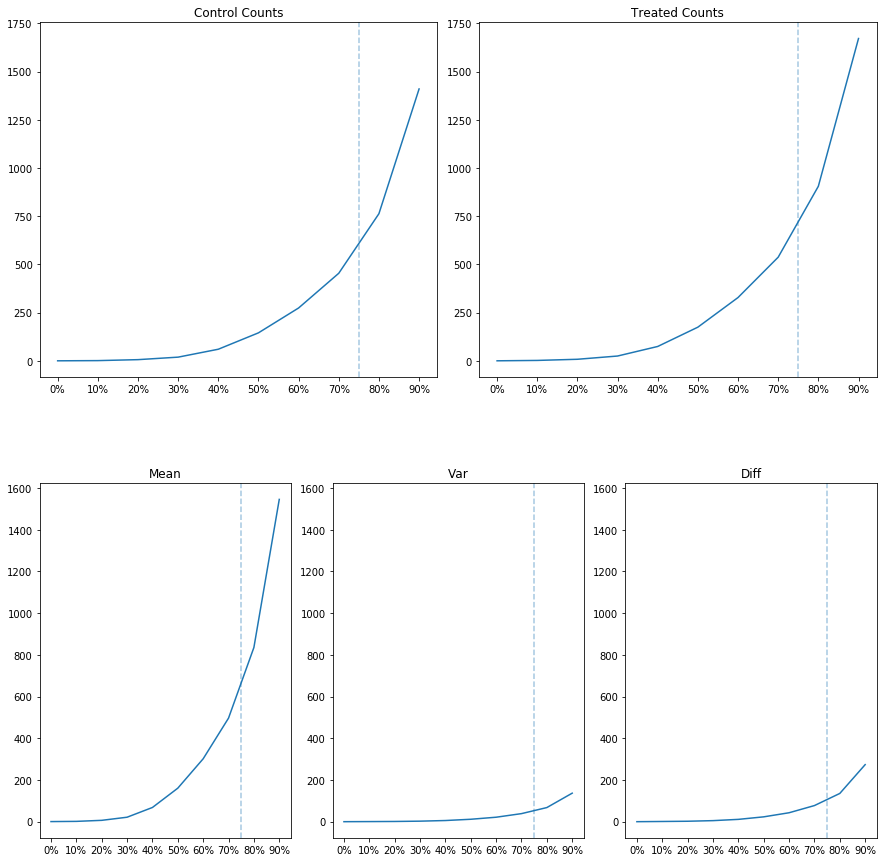

In [61]:
fig = plt.figure()
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0, 0:3])
ax1.plot(idx, deef['D1_Cont'])
plt.title('Control Counts')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax2 = plt.subplot(grid[0, 3:6], sharey=ax1)
ax2.plot(idx, deef['D1_Treat'])
plt.title('Treated Counts')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax3 = plt.subplot(grid[1, 0:2])
ax3.plot(idx, deef['mean'])
plt.title('Mean')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax4 = plt.subplot(grid[1, 2:4], sharey=ax3)
ax4.plot(idx, deef['var'])
plt.title('Var')
plt.axvline(7.5, linestyle='--', alpha=0.4)

ax5 = plt.subplot(grid[1, 4:6], sharey=ax3)
ax5.plot(idx, deef['diff'])
plt.title('Diff')
plt.axvline(7.5, linestyle='--', alpha=0.4)

plt.tight_layout();

In [78]:
perc_filtered = df #[df['diff'] < deef.describe().loc['75%']['diff']]

In [79]:
def rotate(rotation_matrix, points):
    return np.array([np.dot(rotation_matrix, points.values[i, :]) for i in range(len(points.values))])

def calc_theta(coef1, coef2):
    "returns radians"
    return np.abs(
       np.arctan(np.abs(coef1 - coef2) / (1. + (coef1 * coef2)))
   )

def compute_rot_mat(rad, coef):
    if coef < 1.0:
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
    else:
        rotation_matrix = np.array([[np.cos(rad), np.sin(rad)],
                                    [-np.sin(rad), np.cos(rad)]])  
    return rotation_matrix

[[1.09273472]]
[[0.90726528]]
theta 0.09286729328763023
[[ 0.99569093 -0.09273386]
 [ 0.09273386  0.99569093]]


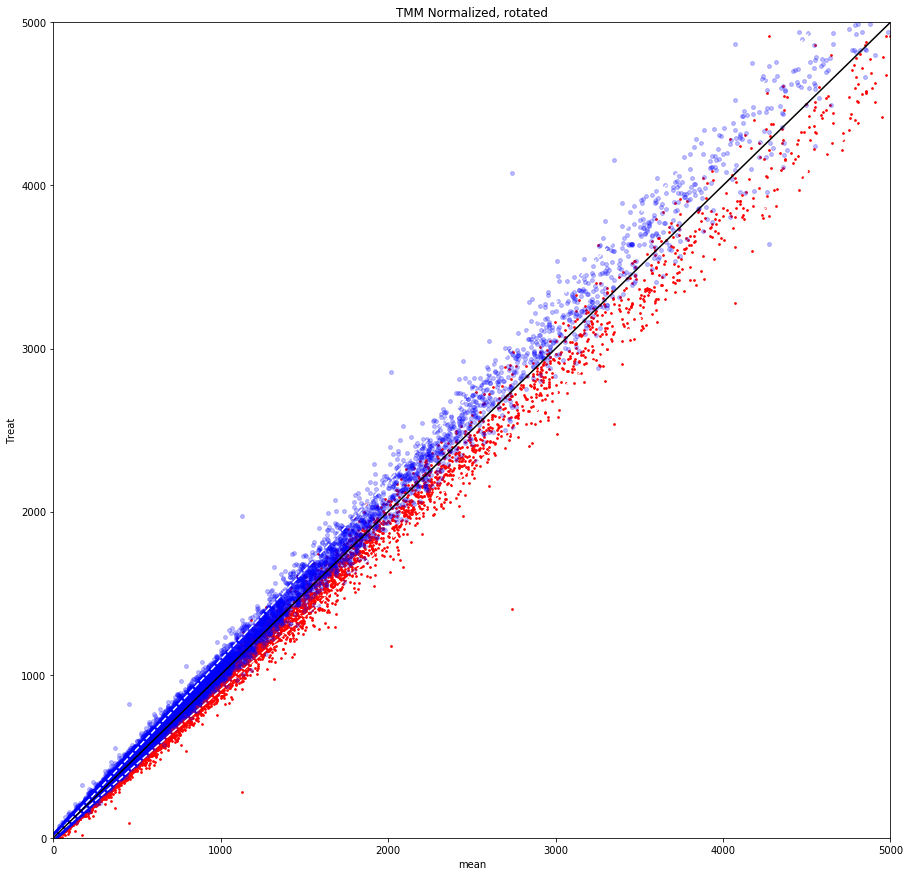

In [80]:
# Compute regression
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# Fit regression line
regCont.fit( perc_filtered['mean'].values.reshape(-1, 1), perc_filtered['D1_Cont'].values.reshape(-1, 1))
regTreat.fit(perc_filtered['mean'].values.reshape(-1, 1), perc_filtered['D1_Treat'].values.reshape(-1, 1))
print(regTreat.coef_)
print(regCont.coef_)

# Correct Bias
df['D1_Cont'] = df['D1_Cont'] - regCont.intercept_
df['D1_Treat'] = df['D1_Treat'] - regTreat.intercept_

# Compute theta in radians
theta = calc_theta(regTreat.coef_[0][0], regCont.coef_[0][0])
print('theta', theta)
# theta=0.1

# Compute rotation Matrix
rotation_matrix_cont = compute_rot_mat(theta, regCont.coef_[0][0])
print(rotation_matrix_cont)

# rotate data
new_cont = rotate(rotation_matrix_cont, df[['mean', 'D1_Cont']])

# reassign data
new_data = pd.DataFrame({'Cont': new_cont[:, 1], 'Treat': df['D1_Treat']})
new_data.loc[:, 'mean'] = new_data.mean(axis=1)

fig, ax = plt.subplots()
new_data.plot('mean', 'Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.95, s=3)
new_data.plot('mean', 'Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.25, s=15)

plt.plot([0, 5000], [0.0, regCont.coef_ * 5000], linestyle='--', color='white')
plt.plot([0, 5000], [0.0, regTreat.coef_ * 5000], linestyle='--', color='white');

ax.plot([0, 10000], [0, 10000], color='black')
ax.set_title("TMM Normalized, rotated");

In [53]:
d1.loc[:, 'diff'] = new_data['Cont'].sub(new_data['Treat']).abs()

In [ ]:
d = df.copy()

In [ ]:
d.head()

In [ ]:
d.loc[:, 'diff'] = d['D1_Cont'].sub(d['D1_Treat']).abs()

In [ ]:
d.describe(percentiles=np.linspace(0, 0.99, num=9))

In [ ]:
d.describe(percentiles=np.linspace(0, 0.99, num=9)).drop(['count', 'mean', 'std', 'min', 'max']).plot(style=['--', '-', '--', '-']);

In [ ]:
new_data[(new_data.apply(lambda x: x < 5000)) & (new_data.apply(lambda x: x > 100))].plot(kind='hist', bins=50, alpha=0.2)

In [ ]:
new_df.dropna(axis=0, inplace=False)

In [ ]:
# This function returns the TMM normalized of ALL sample. The next function needs to normalize by paired time point.
def TMM_all_samples(raw_df, 
                    threshold=10,
                    logfold_change_cutoff = 0.3,
                    absolute_intensity_cutoff = 0.05):
    
    frame = raw_df.copy()
    original_df = raw_df.copy()
    
    # Remove genes that don't have expression, and save them as a separate df to be added in later.
    df = frame.loc[(frame >= threshold).all(axis=1)]
    non_expressed_genes = frame.drop(df.index)
    
    ## Calculate factor quantiles
    ### PERFORM TRIMMING ###
    sample_column_names = df.columns.tolist()
    
    ref_col = sample_column_names[0]
    non_ref_cols = sample_column_names[1:]
    
    # 1. Calculate reference column statistics -- This could be more sophistocated (PCA to find middle most sample?
    # n_kref = column sum for reference column (first column)    
    reference_column_sum = df.loc[:, ref_col].sum()
    reference_column = df[ref_col]

    
    # 2. Calculate the gene-wise logfold changes
    genewise_logfold_change = df.apply(lambda col: np.log2((col/col.sum())/(reference_column/reference_column_sum)))
    
    
    # 3. Calculate the genewise Absolute Intensity
    genewise_abs_intensity = df.apply(lambda col: (np.log2((col/col.sum())*(reference_column/reference_column_sum)))/2.)

    
    # 4 Trim logfold and absolute     
    logfold_mask = genewise_logfold_change.apply(lambda col: col > genewise_logfold_change.quantile(logfold_change_cutoff, axis=1))
    abs_instensity_mask = genewise_abs_intensity.apply(lambda col: col > genewise_abs_intensity.quantile(absolute_intensity_cutoff, axis=1))
    
    import pdb;pdb.set_trace()

    # Remove rows with masked values
    df = df[logfold_mask]
    df = df[abs_instensity_mask]
    df_clean = df.dropna(axis=1)
    
    
    #######################################################
    """ From here we have a trimmed data frame of values that we can use to calculate normalization factors for."""
    # w-r_gk
    weight_r_gk = lambda col: ((col.sum() - col) / (col.sum() * col)) + ((reference_column_sum - reference_column) / (reference_column_sum * reference_column))
    w_r_gk = df_clean.apply(weight_r_gk)
    
    # m-r_gk
    mean_r_gk = lambda col: (np.log2(col / col.sum()) ) / (np.log2(reference_column / reference_column_sum))
    m_r_gk = df_clean.apply(mean_r_gk)
    
    normalization_factors = np.sum(w_r_gk * m_r_gk) / np.sum(w_r_gk)
    
    normalized_df = frame.multiply(normalization_factors, axis=1)
    
    return normalized_df

In [ ]:
TMM_all_samples(raw_df)

In [ ]:
raw_df.loc[(raw_df > 10).any(axis=1)]

In [ ]:
ser =[0.1, 0.5, 0]

In [ ]:
raw_df.mul(ser, axis=1)

In [ ]:
calcNormFactors <- function(object, ...)
UseMethod("calcNormFactors")

calcNormFactors.DGEList <- function(object, method=c("TMM","RLE","upperquartile","none"), refColumn=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10, p=0.75, ...)
#	Scale normalization of RNA-Seq data, for DGEList objects
#	Created 2 October 2014.  Last modified 27 August 2015.
{
	object$samples$norm.factors <- calcNormFactors(object=object$counts, lib.size=object$samples$lib.size, method=method, refColumn=refColumn, logratioTrim=logratioTrim, sumTrim=sumTrim, doWeighting=doWeighting, Acutoff=Acutoff, p=p)
	object
}

calcNormFactors.default <- function(object, lib.size=NULL, method=c("TMM","RLE","upperquartile","none"), refColumn=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10, p=0.75, ...)
#	Scale normalization of RNA-Seq data, for count matrices
#	Mark Robinson.  Edits by Gordon Smyth.
#	Created October 22 October 2009 by Mark Robinson.
#	Last modified 31 July 2015.
{
#	Check object
	x <- as.matrix(object)
	if(any(is.na(x))) stop("NA counts not permitted")

#	Check lib.size
	if(is.null(lib.size)) lib.size <- colSums(x)
	if(any(is.na(lib.size))) stop("NA lib.sizes not permitted")

#	Check method
	method <- match.arg(method)

#	Remove all zero rows
	allzero <- .rowSums(x>0, nrow(x), ncol(x)) == 0
	if(any(allzero)) x <- x[!allzero,,drop=FALSE]

#	Degenerate cases
	if(nrow(x)==0 || ncol(x)==1) method="none"

#	Calculate factors
	f <- switch(method,
		TMM = {
			f75 <- .calcFactorQuantile(data=x, lib.size=lib.size, p=0.75)
			if( is.null(refColumn) ) refColumn <- which.min(abs(f75-mean(f75)))
			if(length(refColumn)==0 | refColumn < 1 | refColumn > ncol(x)) refColumn <- 1
			f <- rep(NA,ncol(x))
			for(i in 1:ncol(x))
				f[i] <- .calcFactorWeighted(obs=x[,i],ref=x[,refColumn], libsize.obs=lib.size[i], libsize.ref=lib.size[refColumn], logratioTrim=logratioTrim, sumTrim=sumTrim, doWeighting=doWeighting, Acutoff=Acutoff)
			f
		},
		RLE = .calcFactorRLE(x)/lib.size,
		upperquartile = .calcFactorQuantile(x,lib.size,p=p),
		none = rep(1,ncol(x))
	)

#	Factors should multiple to one
	f <- f/exp(mean(log(f)))

#	Output
	f
}


.calcFactorRLE <- function (data)
{
	gm <- exp(rowMeans(log(data)))
	apply(data, 2, function(u) median((u/gm)[gm > 0]))
}

.calcFactorQuantile <- function (data, lib.size, p=0.75)
{
#	i <- apply(data<=0,1,all)
#	if(any(i)) data <- data[!i,,drop=FALSE]
	y <- t(t(data)/lib.size)
	f <- apply(y,2,function(x) quantile(x,p=p))
#	f/exp(mean(log(f)))
}

.calcFactorWeighted <- function(obs, ref, libsize.obs=NULL, libsize.ref=NULL, logratioTrim=.3, sumTrim=0.05, doWeighting=TRUE, Acutoff=-1e10)
#	TMM between two libraries
{
	obs <- as.numeric(obs)
	ref <- as.numeric(ref)

	if( is.null(libsize.obs) ) nO <- sum(obs) else nO <- libsize.obs
	if( is.null(libsize.ref) ) nR <- sum(ref) else nR <- libsize.ref

	logR <- log2((obs/nO)/(ref/nR))			# log ratio of expression, accounting for library size
	absE <- (log2(obs/nO) + log2(ref/nR))/2	# absolute expression
	v <- (nO-obs)/nO/obs + (nR-ref)/nR/ref	 # estimated asymptotic variance

#	remove infinite values, cutoff based on A
	fin <- is.finite(logR) & is.finite(absE) & (absE > Acutoff)

	logR <- logR[fin]
	absE <- absE[fin]
	v <- v[fin]

	if(max(abs(logR)) < 1e-6) return(1)

#	taken from the original mean() function
	n <- length(logR)
	loL <- floor(n * logratioTrim) + 1
	hiL <- n + 1 - loL
	loS <- floor(n * sumTrim) + 1
	hiS <- n + 1 - loS

#	keep <- (rank(logR) %in% loL:hiL) & (rank(absE) %in% loS:hiS)
#	a fix from leonardo ivan almonacid cardenas, since rank() can return
#	non-integer values when there are a lot of ties
	keep <- (rank(logR)>=loL & rank(logR)<=hiL) & (rank(absE)>=loS & rank(absE)<=hiS)

	if(doWeighting)
		f <- sum(logR[keep]/v[keep], na.rm=TRUE) / sum(1/v[keep], na.rm=TRUE)
	else
		f <- mean(logR[keep], na.rm=TRUE)

#	Results will be missing if the two libraries share no features with positive counts
#	In this case, return unity
	if(is.na(f)) f <- 0
	2^f
}
